[Sustentaveis] Perfil salvo: C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca/Sustentaveis_cluster_profile.csv


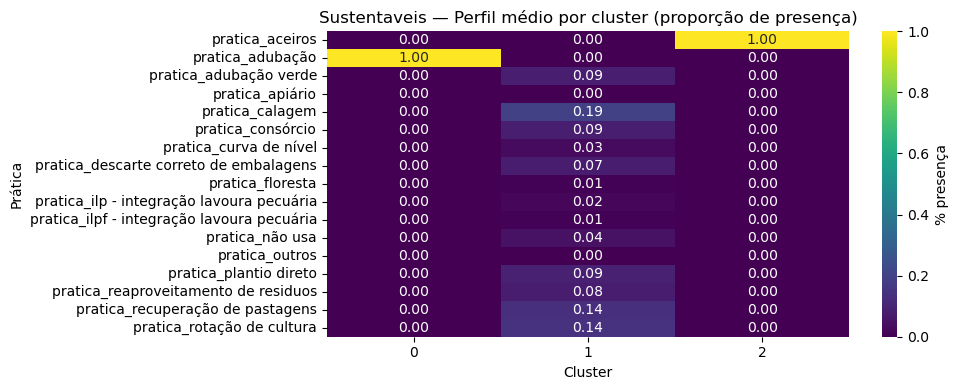

[Sustentaveis] Cruzamento salvo: C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca/Sustentaveis_cluster_degradacao_dist.csv


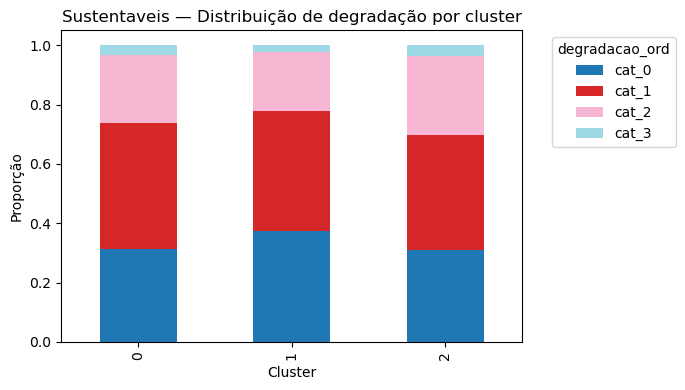

[Sustentaveis] Kruskal-Wallis H = 6.222, p = 0.0446
KW significant → realizando testes pareados (Mann-Whitney) com Bonferroni
Pair (np.int64(0), np.int64(1)): p_raw=0.1347, p_bonf=0.4042, significant=False
Pair (np.int64(0), np.int64(2)): p_raw=0.6284, p_bonf=1.0000, significant=False
Pair (np.int64(1), np.int64(2)): p_raw=0.0235, p_bonf=0.0704, significant=False
[Convencionais] Perfil salvo: C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca/Convencionais_cluster_profile.csv


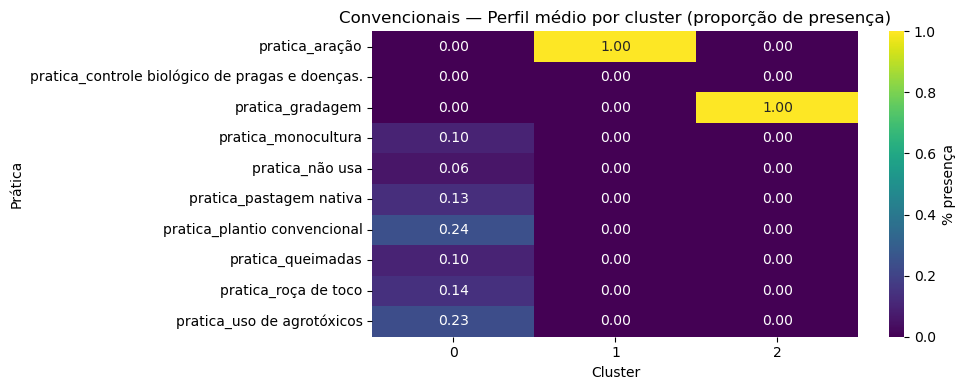

[Convencionais] Cruzamento salvo: C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca/Convencionais_cluster_degradacao_dist.csv


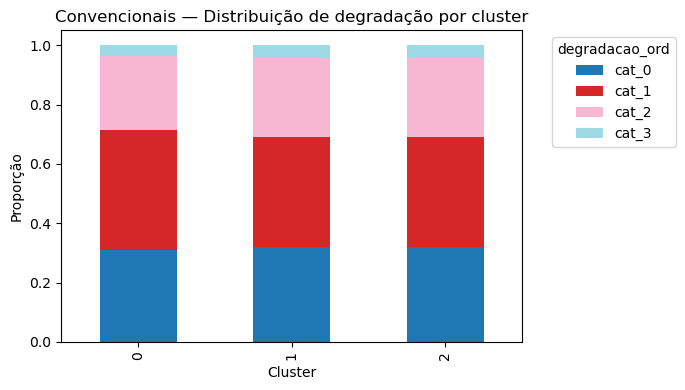

[Convencionais] Kruskal-Wallis H = 0.048, p = 0.9763
KW não-significativo → não há evidência de diferença de degradação entre clusters.


In [3]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# paths (ajuste se precisar)
out_dir = r"C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca"
file_sust = r"C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca/Sustentaveis_with_scores_clusters.csv"
file_conv = r"C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca/Convencionais_with_scores_clusters.csv"

# Função geral para produzir perfis e cruzamento
def analyze_clusters(file_path, label):
    df = pd.read_csv(file_path)
    # identificar colunas de pratica (prefixo 'pratica_')
    praticas = [c for c in df.columns if c.startswith('pratica_')]
    # identificar coluna de cluster (nome pode variar; checar)
    cluster_col = [c for c in df.columns if 'cluster' in c.lower()]
    if len(cluster_col) == 0:
        raise ValueError("Não encontrou coluna de cluster no arquivo.")
    cluster_col = cluster_col[0]
    # garantir degradacao_ord presente
    if 'degradacao_ord' not in df.columns:
        raise ValueError("Coluna degradacao_ord não encontrada.")
    
    # --- PERFIL MÉDIO POR CLUSTER ---
    profile = df.groupby(cluster_col)[praticas].mean()  # proporção de presença
    profile = profile.sort_index()
    profile.to_csv(f"{out_dir}/{label}_cluster_profile.csv", encoding='utf-8-sig')
    print(f"[{label}] Perfil salvo: {out_dir}/{label}_cluster_profile.csv")
    
    # heatmap (práticas x cluster)
    plt.figure(figsize=(10, max(4, len(praticas)*0.2)))
    sns.heatmap(profile.T, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label':'% presença'})
    plt.title(f"{label} — Perfil médio por cluster (proporção de presença)")
    plt.ylabel("Prática")
    plt.xlabel("Cluster")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{label}_cluster_profile_heatmap.png", dpi=300)
    plt.show()
    
    # --- CRUZAMENTO CLUSTER x DEGRADAÇÃO ---
    cross = pd.crosstab(df[cluster_col], df['degradacao_ord'], normalize='index')  # distribuição por linha (cluster)
    cross.to_csv(f"{out_dir}/{label}_cluster_degradacao_dist.csv", encoding='utf-8-sig')
    print(f"[{label}] Cruzamento salvo: {out_dir}/{label}_cluster_degradacao_dist.csv")
    
    # plot barras empilhadas
    cross_plot = cross.copy()
    cross_plot.columns = [f"cat_{c}" for c in cross_plot.columns]  # label safe
    cross_plot.plot(kind='bar', stacked=True, figsize=(7,4), colormap='tab20')
    plt.title(f"{label} — Distribuição de degradação por cluster")
    plt.ylabel("Proporção")
    plt.xlabel("Cluster")
    plt.legend(title='degradacao_ord', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{label}_cluster_degradacao_barstack.png", dpi=300)
    plt.show()
    
    # --- TESTE KRUSKAL-WALLIS (degradacao_ord entre clusters) ---
    groups = [group['degradacao_ord'].values for name, group in df.groupby(cluster_col)]
    kw = kruskal(*groups)
    print(f"[{label}] Kruskal-Wallis H = {kw.statistic:.3f}, p = {kw.pvalue:.4f}")
    
    # se KW significativo, pares Mann-Whitney com correção Bonferroni
    if kw.pvalue < 0.05:
        print("KW significant → realizando testes pareados (Mann-Whitney) com Bonferroni")
        cluster_labels = sorted(df[cluster_col].unique())
        pvals = []
        pairs = []
        for i in range(len(cluster_labels)):
            for j in range(i+1, len(cluster_labels)):
                a = df[df[cluster_col]==cluster_labels[i]]['degradacao_ord']
                b = df[df[cluster_col]==cluster_labels[j]]['degradacao_ord']
                stat, p = mannwhitneyu(a, b, alternative='two-sided')
                pairs.append((cluster_labels[i], cluster_labels[j]))
                pvals.append(p)
        # correção multiple
        rej, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')
        for k, pair in enumerate(pairs):
            print(f"Pair {pair}: p_raw={pvals[k]:.4f}, p_bonf={pvals_corrected[k]:.4f}, significant={rej[k]}")
    else:
        print("KW não-significativo → não há evidência de diferença de degradação entre clusters.")
    
    return profile, cross, kw

# rodar para sustentaveis e convencionais
prof_sust, cross_sust, kw_sust = analyze_clusters(file_sust, "Sustentaveis")
prof_conv, cross_conv, kw_conv = analyze_clusters(file_conv, "Convencionais")
